In [2]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


In [3]:
with tf.device('/GPU:0'):
    model = ...  # Load or build your model


I0000 00:00:1768392699.140956      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768392699.141675      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
import kagglehub
import os
import pandas as pd

# Download the dataset and get the local path
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
print("Downloaded dataset path:", path)

# List all files and directories inside the downloaded dataset
print("Contents of downloaded folder:", os.listdir(path))

# Find actual dataset directory (e.g., it may not have a "Dataset" folder)
for root, dirs, files in os.walk(path):
    print("Checking directory:", root)
    if "Train" in dirs and "Validation" in dirs and "Test" in dirs:
        dataset_root = root
        break

# Now assign paths based on the actual dataset directory structure
train_directory = os.path.join(dataset_root, "Train")
val_directory = os.path.join(dataset_root, "Validation")
test_directory = os.path.join(dataset_root, "Test")

print("Train folder:", train_directory)
print("Validation folder:", val_directory)
print("Test folder:", test_directory)

# Check image distribution
categories = os.listdir(train_directory)
nums = {label: len(os.listdir(os.path.join(train_directory, label))) for label in categories}
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of Images"])
print("Image Distribution:\n", img_per_class)

Downloaded dataset path: /kaggle/input/deepfake-and-real-images
Contents of downloaded folder: ['Dataset']
Checking directory: /kaggle/input/deepfake-and-real-images
Checking directory: /kaggle/input/deepfake-and-real-images/Dataset
Train folder: /kaggle/input/deepfake-and-real-images/Dataset/Train
Validation folder: /kaggle/input/deepfake-and-real-images/Dataset/Validation
Test folder: /kaggle/input/deepfake-and-real-images/Dataset/Test
Image Distribution:
       No. of Images
Fake          70001
Real          70001


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
import seaborn as sns
import os
import pandas as pd

In [6]:
import os

base_path = "/kaggle/input/deepfake-and-real-images/Dataset"

train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
val_path = os.path.join(base_path, "Validation")

print("Train folder:", train_path)
print("Test folder:", test_path)
print("Validation folder:", val_path)


Train folder: /kaggle/input/deepfake-and-real-images/Dataset/Train
Test folder: /kaggle/input/deepfake-and-real-images/Dataset/Test
Validation folder: /kaggle/input/deepfake-and-real-images/Dataset/Validation


In [8]:
train_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

In [9]:
categories = os.listdir(train_directory)
nums = {label: len(os.listdir(os.path.join(train_directory, label))) for label in categories}
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of Images"])
print("Image Distribution:\n", img_per_class)

Image Distribution:
       No. of Images
Fake          70001
Real          70001


In [11]:
# Define image dimensions and batch size
img_height, img_width = 180, 180
batch_size = 32

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [13]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Num GPUs Available: 2
GPU Device Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Load ResNet50 base model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
# Build model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(384, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # or Dense(2, softmax) if categorical
])


In [18]:
# Compile model
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()
     

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 6, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       786,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,374,913 (92.98 MB)

 Trainable params: 787,201 (3.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Resnet50.keras', save_best_only=True)
]

In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

In [18]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\nOverfitting Gap: {val_acc - train_acc:.4f}")
print(train_acc)
print(val_acc)

NameError: name 'history' is not defined

NameError: name 'history' is not defined

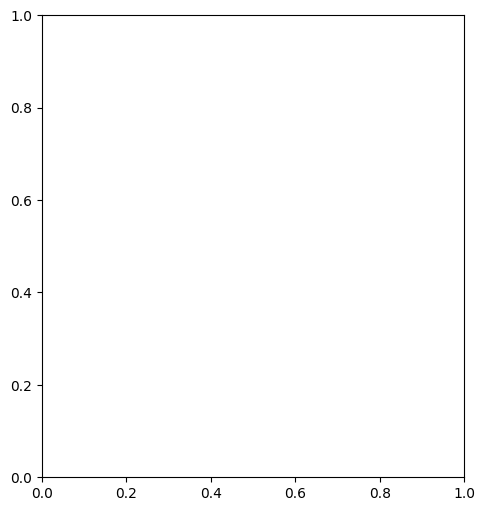

In [19]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Overfitting Gap Visualization
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
overfitting_gap = [v - t for v, t in zip(val_acc, train_acc)]
plt.figure(figsize=(6, 4))
plt.plot(overfitting_gap, label='Overfitting Gap (Val - Train Acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.title('Overfitting Gap')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model.save('resnet50_model_explicit.h5')
model.save("resnet50_model_explicit.keras")

In [ ]:
import shutil
import os

model_path = "/kaggle/working/resnet50_model_explicit.keras"
zip_path = "/kaggle/working/resnet50_model_explicit"

if os.path.exists(model_path):
    shutil.make_archive(zip_path, "zip", "/kaggle/working", "resnet50_model_explicit.keras")
    print("ZIP created successfully")
else:
    print("Model file not found")


In [ ]:
resnet50_model_explicit.zip


In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# 1. Define the path to your image here
# If you uploaded it to Kaggle, it might look like '/kaggle/working/my_test_image.jpg'
image_path = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Real/real_100.jpg" 

def check_deepfake(path):
    # Load the model (only if it's not already in memory)
    # model = tf.keras.models.load_model('resnet50_model_explicit.keras')

    # Load and resize image
    img = image.load_img(path, target_size=(180, 180))
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    
    # Preprocess the input (scaling pixels)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    score = prediction[0][0]

    # Result logic
    if score > 0.5:
        print(f"Result: REAL (Confidence: {score*100:.2f}%)")
    else:
        print(f"Result: DEEPFAKE (Confidence: {(1-score)*100:.2f}%)")

# 2. Run the function
check_deepfake(image_path)

I0000 00:00:1768393187.936396     126 service.cc:152] XLA service 0x7c5064049da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768393187.936430     126 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768393187.936434     126 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768393188.721202     126 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Result: DEEPFAKE (Confidence: 65.95%)


I0000 00:00:1768393191.528075     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path from your screenshot: Dataset name 'trainedmodelfile' + filename
model_path = '/kaggle/input/trainedmodelfile/resnet50_model_explicit.keras'

# Load the already trained model
model = load_model(model_path)
print("Model loaded successfully from Kaggle input!")

Model loaded successfully from Kaggle input!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


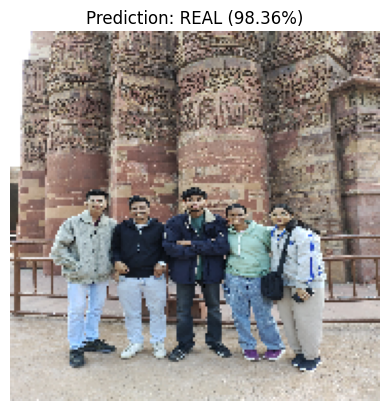

File: IMG_20241230_143507.jpg
Raw Score: 0.9836


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1. Update this path to the image you want to test
external_image_path = "/kaggle/input/custom-data/test/IMG_20241230_143507.jpg"

def evaluate_single_image(img_path):
    # Load and resize (matches your training size 180x180)
    img = image.load_img(img_path, target_size=(180, 180))
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # IMPORTANT: Apply ResNet50 preprocessing
    # This centers the data correctly for the ResNet layers
    img_preprocessed = preprocess_input(img_batch)

    # Make Prediction
    prediction = model.predict(img_preprocessed)
    score = prediction[0][0]

    # Classification logic (Sigmoid output)
    # 0 = Deepfake, 1 = Real (Based on alphabetical order: Fake vs Real)
    result = "REAL" if score > 0.5 else "DEEPFAKE"
    confidence = score if score > 0.5 else 1 - score

    # Visualize result
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"File: {img_path.split('/')[-1]}")
    print(f"Raw Score: {score:.4f}")

# Run the evaluation
evaluate_single_image(external_image_path)

Generating heatmap for: IMG_20241230_143507.jpg...


/tmp/ipykernel_55/108106615.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


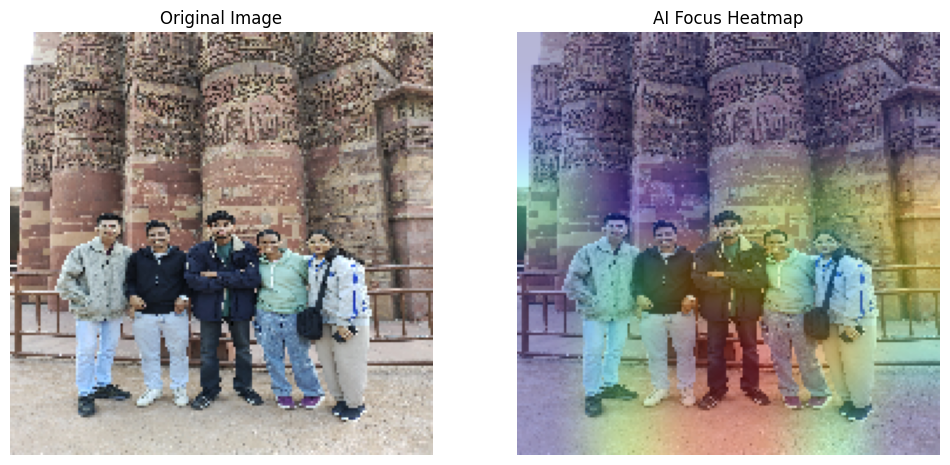

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

def get_gradcam_manual(img_array, model):
    """
    Manually computes Grad-CAM by splitting the model into Base and Head.
    This avoids 'Graph Disconnected' and 'Layer Not Called' errors.
    """
    # 1. Split the model
    # model.layers[0] is your ResNet50 base
    base_model = model.layers[0] 
    
    # model.layers[1:] are your Classifier layers (GAP, Dense, Dropout, Output)
    classifier_layers = model.layers[1:]
    
    # 2. Compute Gradients using Tape
    with tf.GradientTape() as tape:
        # Cast input to ensure it's a tensor
        inputs = tf.cast(img_array, tf.float32)
        
        # A. Pass input through the Base (ResNet) to get feature maps
        # The output of ResNet50 (include_top=False) IS the feature map we need
        feature_maps = base_model(inputs)
        
        # B. Watch the feature maps! This tells TensorFlow to track this tensor
        tape.watch(feature_maps)
        
        # C. Pass features through the rest of the Classifier
        x = feature_maps
        for layer in classifier_layers:
            x = layer(x)
        predictions = x
        
        # D. Get the score of the winning class
        # (For binary, we just take the raw output, or the max if it were categorical)
        # Since you have 1 output node (sigmoid), predictions[0][0] is the score
        score = predictions[0][0]

    # 3. Calculate Gradient of the Score w.r.t Feature Maps
    grads = tape.gradient(score, feature_maps)
    
    # 4. Global Average Pooling of Gradients
    # Average the gradients across the height/width axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 5. Multiply each feature map channel by its "importance" (pooled gradient)
    feature_maps = feature_maps[0]
    heatmap = feature_maps @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 6. Normalize the heatmap (ReLU + Normalize to 0-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_heatmap(img_path, heatmap, alpha=0.4):
    # Load original image
    img = image.load_img(img_path, target_size=(180, 180))
    img = image.img_to_array(img)

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Colorize (Jet colormap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match original image size
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.load_img(img_path, target_size=(180, 180)))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Focus Heatmap")
    plt.axis('off')
    plt.show()

# --- EXECUTION ---
# Ensure the image is preprocessed correctly
# (Assuming external_image_path is already defined from your previous cells)
img = image.load_img(external_image_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

print(f"Generating heatmap for: {external_image_path.split('/')[-1]}...")

# Run the new manual function
heatmap = get_gradcam_manual(img_array, model)
display_heatmap(external_image_path, heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


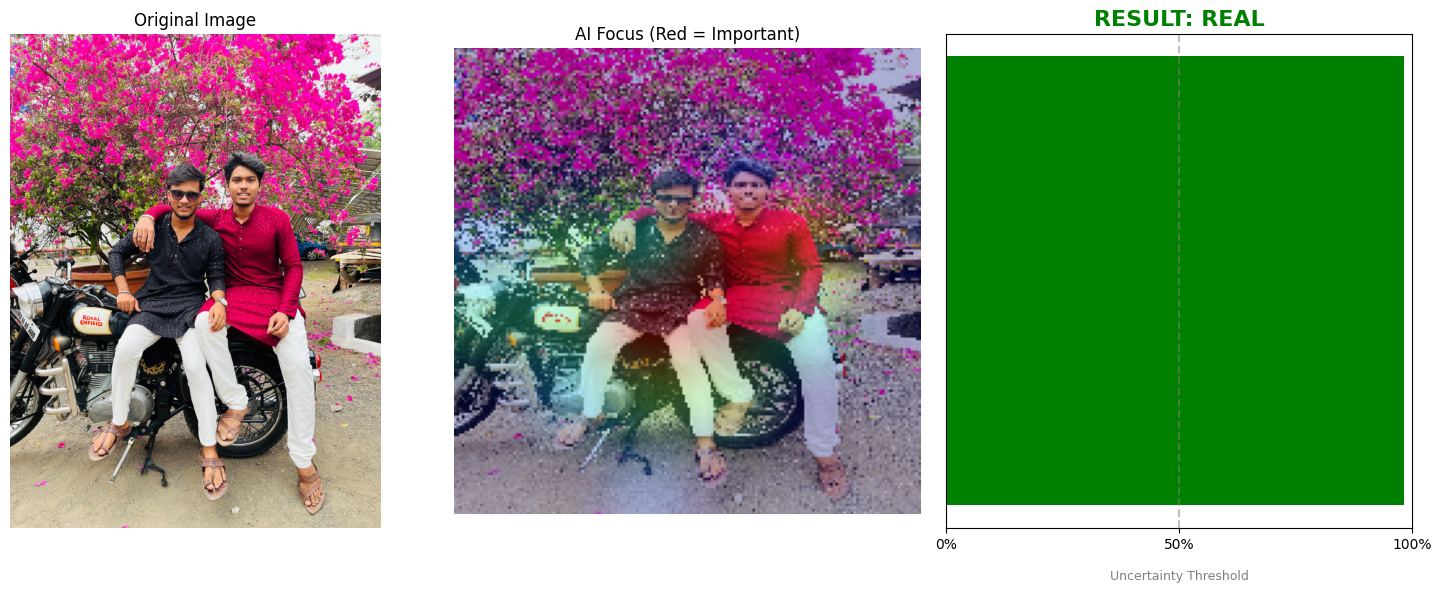


 📝 AI EXPLAINABILITY REPORT: REAL
► CONFIDENCE SCORE: 98.20%
► PRIMARY FOCUS:    The AI found the most evidence in the **Eyes/Forehead**.

✅ WHY IS THIS REAL?
   The model detected natural noise patterns and consistent lighting
   that are difficult to replicate in deepfakes.



/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [65]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib  # <--- This was missing!
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def get_gradcam_manual(img_array, model):
    """
    Manually computes Grad-CAM by splitting the model into Base and Head.
    """
    base_model = model.layers[0] 
    classifier_layers = model.layers[1:]
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        feature_maps = base_model(inputs)
        tape.watch(feature_maps)
        
        x = feature_maps
        for layer in classifier_layers:
            x = layer(x)
        predictions = x
        score = predictions[0][0]

    grads = tape.gradient(score, feature_maps)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    feature_maps = feature_maps[0]
    heatmap = feature_maps @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def explain_decision_text(heatmap):
    """Generates a text explanation based on heatmap focus areas."""
    top_third = heatmap[:60, :]     # Eyes/Forehead
    mid_third = heatmap[60:120, :]  # Nose/Cheeks
    bot_third = heatmap[120:, :]    # Mouth/Chin
    
    scores = {
        "Eyes/Forehead": np.mean(top_third),
        "Nose/Cheeks": np.mean(mid_third),
        "Mouth/Chin": np.mean(bot_third)
    }
    dominant_region = max(scores, key=scores.get)
    return dominant_region

def generate_full_report(img_path, model):
    # 1. PREPROCESSING
    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img) # converts to (180, 180, 3)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Preprocess (Standard ResNet50 preprocessing)
    img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img_batch.copy())

    # 2. PREDICTION
    prediction = model.predict(img_preprocessed)
    score = prediction[0][0]
    
    # Logic: 0=Fake, 1=Real (Alphabetical)
    label = "REAL" if score > 0.5 else "DEEPFAKE"
    confidence = score if score > 0.5 else 1 - score
    color = 'green' if label == "REAL" else 'red'

    # 3. GENERATE HEATMAP
    heatmap = get_gradcam_manual(img_preprocessed, model)
    
    # Process Heatmap for Display
    # Use matplotlib.colormaps safely
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[np.uint8(255 * heatmap)]
    
    jet_heatmap = image.array_to_img(jet_heatmap)
    
    # Resize heatmap to match original image size
    # img_array.shape is (180, 180, 3) -> (height, width, channels)
    # resize expects (width, height) -> (180, 180)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * 0.4 + img_array
    superimposed_img = image.array_to_img(superimposed_img)

    # 4. VISUALIZATION DASHBOARD
    plt.figure(figsize=(15, 6))
    
    # Plot A: Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image.load_img(img_path))
    plt.title("Original Image", fontsize=12)
    plt.axis('off')
    
    # Plot B: Heatmap Explanation
    plt.subplot(1, 3, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Focus (Red = Important)", fontsize=12)
    plt.axis('off')
    
    # Plot C: Confidence Gauge
    plt.subplot(1, 3, 3)
    plt.barh([0], [confidence], color=color, height=0.3)
    plt.xlim(0, 1)
    plt.yticks([])
    plt.xticks([0, 0.5, 1.0], ['0%', '50%', '100%'])
    plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.title(f"RESULT: {label}", fontsize=16, fontweight='bold', color=color)
    plt.text(0.5, -0.2, 'Uncertainty Threshold', ha='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    plt.show()

    # 5. TEXT REPORT
    focus_area = explain_decision_text(heatmap)
    
    print("\n" + "="*50)
    print(f" 📝 AI EXPLAINABILITY REPORT: {label}")
    print("="*50)
    print(f"► CONFIDENCE SCORE: {confidence*100:.2f}%")
    print(f"► PRIMARY FOCUS:    The AI found the most evidence in the **{focus_area}**.")
    
    if label == "DEEPFAKE":
        print("\n🔍 WHY IS THIS FAKE?")
        print("   The model detected irregularities typically found in synthetic media.")
        if focus_area == "Eyes/Forehead":
            print("   • Potential Issue: Unnatural blinking, pupil shape, or eyebrow movements.")
        elif focus_area == "Mouth/Chin":
            print("   • Potential Issue: Lip-sync errors or unnatural mouth distortions.")
        elif focus_area == "Nose/Cheeks":
            print("   • Potential Issue: Skin texture smoothing or lighting inconsistencies.")
    else:
        print("\n✅ WHY IS THIS REAL?")
        print("   The model detected natural noise patterns and consistent lighting")
        print("   that are difficult to replicate in deepfakes.")
    print("="*50 + "\n")

# --- USER INPUT ---
# Update this path to test different images
image_path = "/kaggle/input/real-trad-day/WhatsApp Image 2025-04-02 at 00.10.59_b0d7ccf5.jpg"

if tf.io.gfile.exists(image_path):
    generate_full_report(image_path, model)
else:
    print("Error: Image path not found. Please check the file path.")